<a href="https://colab.research.google.com/github/Arshia786-stack/LLM-Bias-Detection/blob/main/NLP_BioGPT_%2B_DEATH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **NLP Assignment**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!pip install -q kaggle
!mkdir kaggle
!cp kaggle.json kaggle/
!ls kaggle
!chmod 600 kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d arshiamu/DataforBias

kaggle.json
ref                                                               title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ---------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                 Chocolate Sales Data 📊🍫                             14473  2025-03-19 03:51:40.270000          13944        245  1.0              
adilshamim8/student-depression-dataset                            Student Depression Dataset                         467020  2025-03-13 03:12:30.423000           5710         93  1.0              
abdulmalik1518/mobiles-dataset-2025                               Mobiles Dataset (2025)                              20314  2025-02-18 06:50:24.370000          18951        310  1.0              
bad

In [ ]:
!unzip /content/DataforBias.zip

Archive:  /content/DataforBias.zip
  inflating: ADMISSIONS.csv          
  inflating: PATIENTS.csv            


In [ ]:
!pip install transformers fairlearn datasets scikit-learn pandas torch aif360 shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
import shap

In [ ]:
! pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.1 MB/s eta 0:00:00


## **LLM 1 : BIOGPT**

In [ ]:
model_name = "microsoft/BioGPT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification (death: 1, survival: 0)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Some weights of BioGptForSequenceClassification were not initialized from the model checkpoint at microsoft/BioGPT and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**PREPROCESSING OF DATA**

---



In [ ]:
def load_mimic_data():
    admissions_df = pd.read_csv("ADMISSIONS.csv")  # Clinical notes
    patients_df = pd.read_csv("PATIENTS.csv")  # Demographics (age, gender, ethnicity)

    # Merge datasets on SUBJECT_ID
    ehr_data = admissions_df.merge(patients_df, on="SUBJECT_ID")
    return ehr_data
ehr_data = load_mimic_data()
ehr_data.columns
ehr_data = ehr_data[['SUBJECT_ID' , 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']]
print(len(ehr_data))
ehr_data = ehr_data.dropna(subset=['SUBJECT_ID' , 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG'])
print(len(ehr_data))


58976
48588


In [ ]:
ehr_data["TEXT_INPUT"] = (
    "Patient is " + ehr_data["GENDER"] +
    ", marital status: " + ehr_data["MARITAL_STATUS"] +
    ", ethnicity: " + ehr_data["ETHNICITY"] +
    ", religion: " + ehr_data["RELIGION"] +
    ". Diagnosis: " + ehr_data["DIAGNOSIS"]
)

# Now tokenize TEXT_INPUT instead of just DIAGNOSIS
tokenized_output = tokenizer(
    ehr_data["TEXT_INPUT"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [ ]:
ehr_data["TEXT_INPUT"]

,TEXT_INPUT
0,"Patient is F, marital status: MARRIED, ethnici..."
1,"Patient is M, marital status: MARRIED, ethnici..."
2,"Patient is M, marital status: MARRIED, ethnici..."
3,"Patient is M, marital status: SINGLE, ethnicit..."
4,"Patient is M, marital status: MARRIED, ethnici..."
...,...
58971,"Patient is F, marital status: SINGLE, ethnicit..."
58972,"Patient is F, marital status: WIDOWED, ethnici..."
58973,"Patient is M, marital status: MARRIED, ethnici..."
58974,"Patient is F, marital status: MARRIED, ethnici..."


**HUGGING FACE DATASET CREATION**

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
import torch

# Assuming you're using BioGPT or ClinicalBERT
model_name = "microsoft/biogpt"  # Replace with the model you're using
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the TEXT_INPUT column
def tokenize_function(examples):
    return tokenizer(examples['TEXT_INPUT'], padding='max_length', truncation=True, max_length=128)

# Convert dataframe to Hugging Face Dataset
dataset = Dataset.from_pandas(ehr_data)

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Rename 'HOSPITAL_EXPIRE_FLAG' to 'label' for training
dataset = dataset.rename_column("HOSPITAL_EXPIRE_FLAG", "label")  # Target variable

config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/696k [00:00<?, ?B/s]

Map:   0%|          | 0/48588 [00:00<?, ? examples/s]

**TRAINING OF DATA**

In [ ]:
# Step 6: Train/Test Split
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

**FINE TUNING OF LLM**

In [ ]:
# Step 7: Fine-Tune the model
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01
)

# Define the Trainer with model, arguments, and datasets
trainer = Trainer(
    model=model,  # Load your pretrained model (BioGPT/ClinicalBERT)
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Start training
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arshiamu (arshiamu-usc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.322200,0.329244
2,0.308500,0.320363
3,0.280400,0.318032


TrainOutput(global_step=7290, training_loss=0.30857397741414555, metrics={'train_runtime': 10309.9738, 'train_samples_per_second': 11.31, 'train_steps_per_second': 0.707, 'total_flos': 2.707413040889856e+16, 'train_loss': 0.30857397741414555, 'epoch': 3.0})

**SAVING THE MODEL**

In [ ]:
# Create a directory to save the fine-tuned model
model_save_path = "./fine_tuned_model"
trainer.save_model(model_save_path)  # Saves model + tokenizer

# Save tokenizer separately (just to be safe)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved successfully at {model_save_path}")


Model saved successfully at ./fine_tuned_model


**1a. PREDICTIONS ON ETHNICITY**

In [ ]:
# Step 8: Make Predictions
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=1).item()

# Apply predictions to your data
ehr_data['predictions'] = ehr_data['TEXT_INPUT'].apply(lambda x: predict(x))

**COMPUTING FAIRNESS METRICS**

In [ ]:
# Step 9: Compute Fairness Metrics
# ehr_data['label'] does not exist, use 'HOSPITAL_EXPIRE_FLAG' instead
y_true = ehr_data['HOSPITAL_EXPIRE_FLAG'].values  # Actual hospital outcome
y_pred = ehr_data['predictions'].values  # Predicted outcomes
groups = ehr_data['ETHNICITY'].values  # Sensitive feature (e.g., ETHNICITY or GENDER)

# Calculate fairness metrics using your preferred method
# Using demo functions for fairness metrics as placeholders
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

dem_parity = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups) # Added keyword argument sensitive_features
eq_odds = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)

print(f"Demographic Parity Difference: {dem_parity:.4f}")
print(f"Equalized Odds Difference: {eq_odds:.4f}")

Demographic Parity Difference: 0.0435
Equalized Odds Difference: 0.5000


In [ ]:
import pandas as pd

# Create a DataFrame to analyze group-level disparities
fairness_df = ehr_data.groupby("ETHNICITY").agg(
    total_samples=("ETHNICITY", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")  # Predicted death cases
)
# Compute positive rates (probability of being classified as "1")
fairness_df["actual_positive_rate"] = fairness_df["positive_actual"] / fairness_df["total_samples"]
fairness_df["predicted_positive_rate"] = fairness_df["positive_predicted"] / fairness_df["total_samples"]
# Show results
print(fairness_df)

                                                    total_samples  \
ETHNICITY                                                           
AMERICAN INDIAN/ALASKA NATIVE                                  22   
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNI...              3   
ASIAN                                                         774   
ASIAN - ASIAN INDIAN                                           81   
ASIAN - CAMBODIAN                                              17   
ASIAN - CHINESE                                               247   
ASIAN - FILIPINO                                               23   
ASIAN - JAPANESE                                                6   
ASIAN - KOREAN                                                 12   
ASIAN - OTHER                                                  12   
ASIAN - THAI                                                    4   
ASIAN - VIETNAMESE                                             50   
BLACK/AFRICAN                     

In [ ]:
ehr_data.to_csv('ehr_data.csv')

In [ ]:
from sklearn.metrics import confusion_matrix

# Store results per ethnicity
ethnicity_analysis = []

for ethnicity in ehr_data["ETHNICITY"].unique():
    subset = ehr_data[ehr_data["ETHNICITY"] == ethnicity]

    # Compute confusion matrix
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):  # Check for a 2x2 matrix (binary classification)
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Check for a 1x1 matrix (only one class present)
        # Handle this case (e.g., set values to 0 or print a warning)
        tn, fp, fn, tp = cm[0][0], 0, 0, 0  # Assuming one class was predicted
    else:
        # Handle other cases or print an error
        print(f"Unexpected confusion matrix shape for {ethnicity}: {cm.shape}")
        continue

    # Compute rates
    # Handle potential ZeroDivisionError when denominator is 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    ethnicity_analysis.append({
        "Ethnicity": ethnicity,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert to DataFrame
ethnicity_bias_df = pd.DataFrame(ethnicity_analysis)

# Display results
print(ethnicity_bias_df)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


                                            Ethnicity  False Positive Rate  \
0                                               WHITE             0.002904   
1                               UNKNOWN/NOT SPECIFIED             0.007743   
2                                MULTI RACE ETHNICITY             0.000000   
3                                  HISPANIC OR LATINO             0.000822   
4                          PATIENT DECLINED TO ANSWER             0.007500   
5                              BLACK/AFRICAN AMERICAN             0.002147   
6                                               ASIAN             0.001464   
7                        HISPANIC/LATINO - GUATEMALAN             0.000000   
8                                               OTHER             0.004274   
9                                  ASIAN - VIETNAMESE             0.000000   
10                      AMERICAN INDIAN/ALASKA NATIVE             0.000000   
11                                    WHITE - RUSSIAN           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th

In [ ]:
ethnicity_bias_df.to_csv('ethnicity_bias_df.csv')

In [ ]:
import pandas as pd
ehr_data = pd.read_csv('ehr_data.csv')
fairness_df = pd.read_csv('fairness_results.csv')
ethnicity_bias_df = pd.read_csv('ethnicity_bias_df.csv')

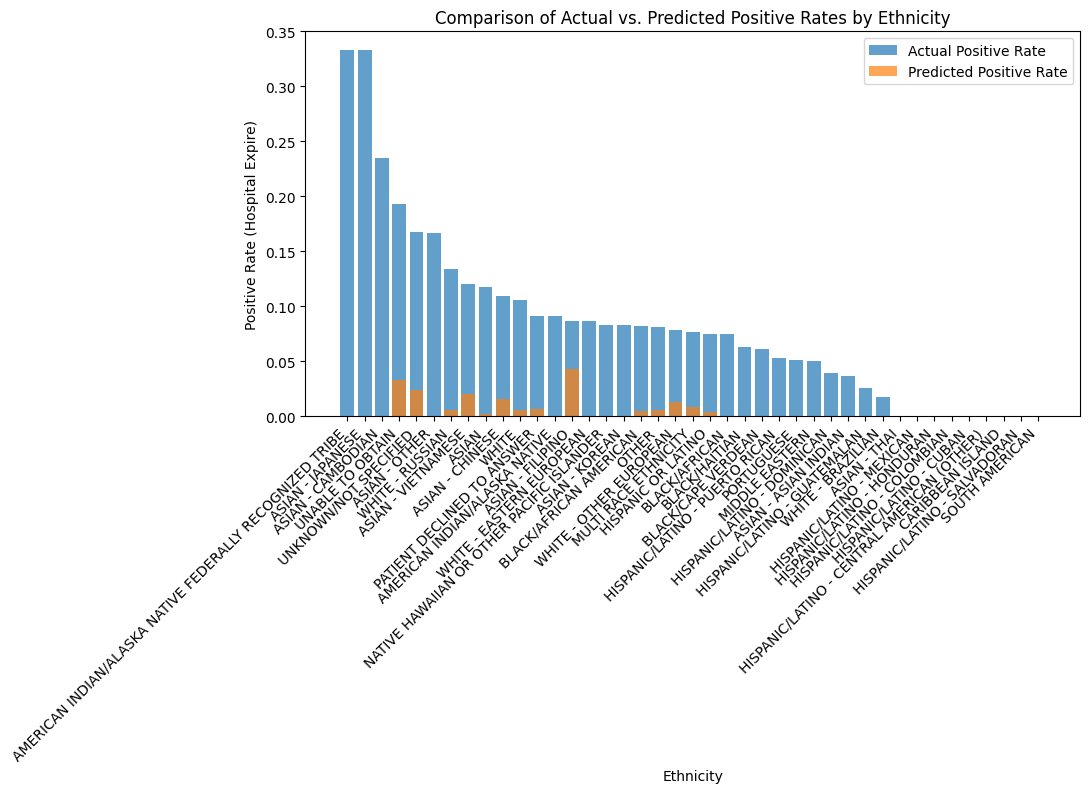

In [ ]:
import matplotlib.pyplot as plt

# Sort by actual positive rate for better visualization
fairness_df = fairness_df.sort_values(by="actual_positive_rate", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(fairness_df["ETHNICITY"], fairness_df["actual_positive_rate"], label="Actual Positive Rate", alpha=0.7)
plt.bar(fairness_df["ETHNICITY"], fairness_df["predicted_positive_rate"], label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Ethnicity")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Ethnicity")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()


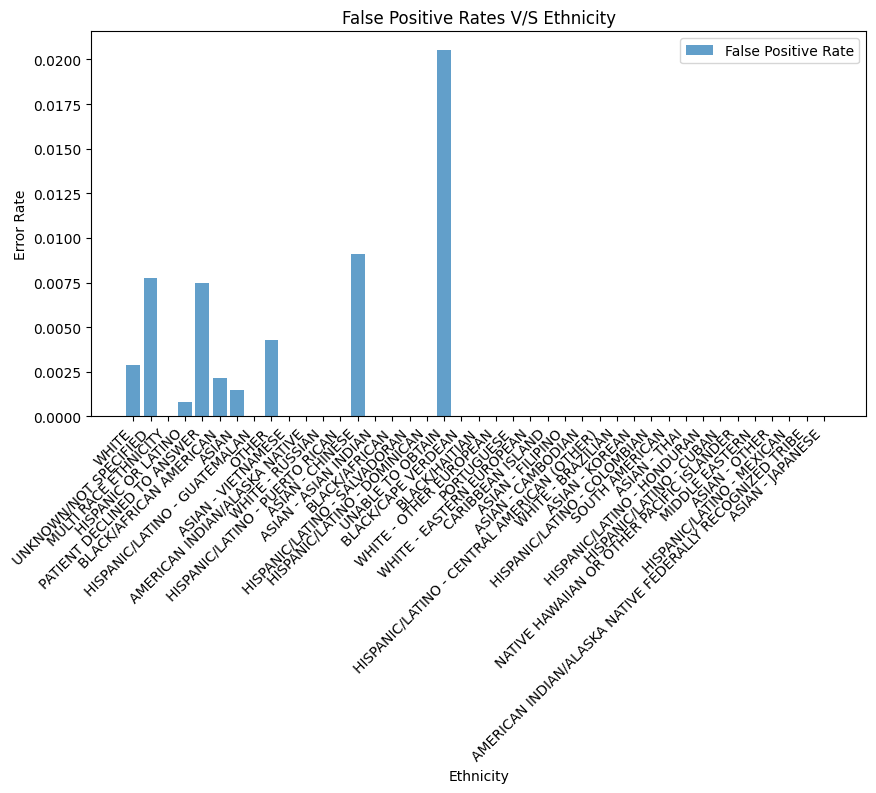

In [ ]:
# Plot FPR & FNR for each ethnicity
plt.figure(figsize=(10, 5))
plt.bar(ethnicity_bias_df["Ethnicity"], ethnicity_bias_df["False Positive Rate"], label="False Positive Rate", alpha=0.7)
plt.xlabel("Ethnicity")
plt.ylabel("Error Rate")
plt.title("False Positive Rates V/S Ethnicity")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()


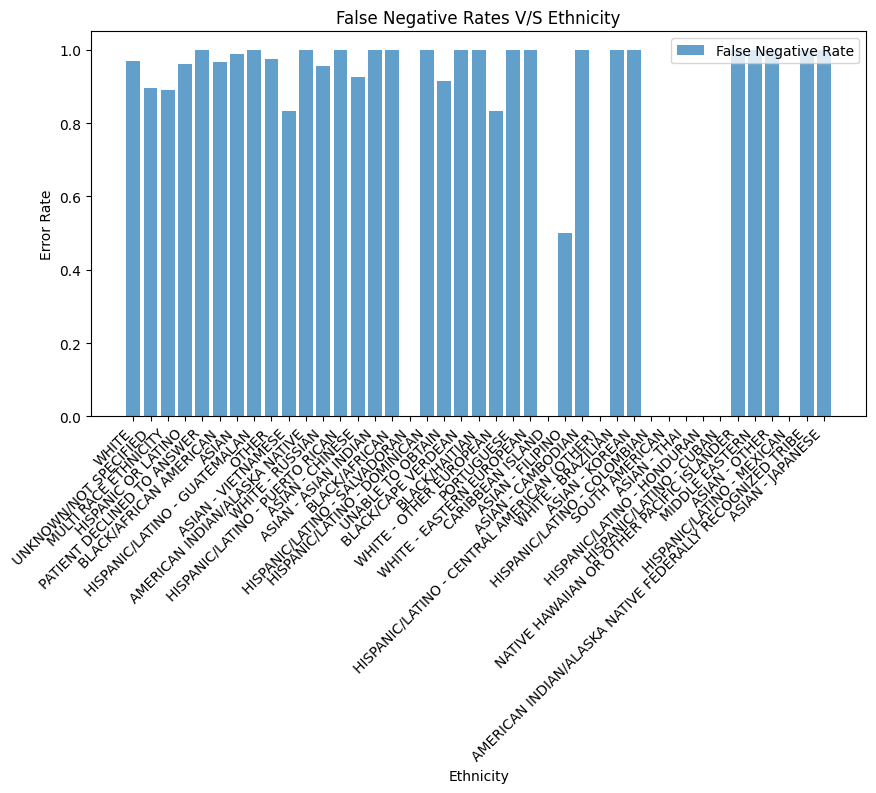

In [ ]:
# Plot FPR & FNR for each ethnicity
plt.figure(figsize=(10, 5))
plt.bar(ethnicity_bias_df["Ethnicity"], ethnicity_bias_df["False Negative Rate"], label="False Negative Rate", alpha=0.7)
plt.xlabel("Ethnicity")
plt.ylabel("Error Rate")
plt.title("False Negative Rates V/S Ethnicity")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Step 9: Compute Fairness Metrics
# ehr_data['label'] does not exist, use 'HOSPITAL_EXPIRE_FLAG' instead
y_true = ehr_data['HOSPITAL_EXPIRE_FLAG'].values  # Actual hospital outcome
y_pred = ehr_data['predictions'].values  # Predicted outcomes
groups = ehr_data['GENDER'].values  # Sensitive feature (e.g., ETHNICITY or GENDER)

# Calculate fairness metrics using your preferred method
# Using demo functions for fairness metrics as placeholders
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

dem_parity = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups) # Added keyword argument sensitive_features
eq_odds = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)

print(f"Demographic Parity Difference: {dem_parity:.4f}")
print(f"Equalized Odds Difference: {eq_odds:.4f}")

Demographic Parity Difference: 0.0004
Equalized Odds Difference: 0.0028


In [ ]:
! pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 8.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Create a DataFrame to analyze group-level disparities for Gender
gender_fairness_df = ehr_data.groupby("GENDER").agg(
    total_samples=("GENDER", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")          # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
gender_fairness_df["actual_positive_rate"] = gender_fairness_df["positive_actual"] / gender_fairness_df["total_samples"]
gender_fairness_df["predicted_positive_rate"] = gender_fairness_df["positive_predicted"] / gender_fairness_df["total_samples"]

# Show results
print(gender_fairness_df)

        total_samples  positive_actual  positive_predicted  \
GENDER                                                       
F               21381             2390                 148   
M               27207             2760                 200   

        actual_positive_rate  predicted_positive_rate  
GENDER                                                 
F                   0.111781                 0.006922  
M                   0.101444                 0.007351  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ----- Gender-Level Bias Analysis -----
# Store results per gender
gender_analysis = []

for gender in ehr_data["GENDER"].unique():
    subset = ehr_data[ehr_data["GENDER"] == gender]

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Only one class present
        tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        print(f"Unexpected confusion matrix shape for {gender}: {cm.shape}")
        continue

    # Compute False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    gender_analysis.append({
        "Gender": gender,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert results into a DataFrame and display them
gender_bias_df = pd.DataFrame(gender_analysis)
print(gender_bias_df)

# ----- Gender-Level Fairness Analysis -----
# Group the data by GENDER and compute total counts and positive counts
gender_fairness_df = ehr_data.groupby("GENDER").agg(
    total_samples=("GENDER", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")           # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
gender_fairness_df["actual_positive_rate"] = gender_fairness_df["positive_actual"] / gender_fairness_df["total_samples"]
gender_fairness_df["predicted_positive_rate"] = gender_fairness_df["positive_predicted"] / gender_fairness_df["total_samples"]

print(gender_fairness_df)

  Gender  False Positive Rate  False Negative Rate
0      F             0.002896             0.961088
1      M             0.003477             0.958333
        total_samples  positive_actual  positive_predicted  \
GENDER                                                       
F               21381             2390                 148   
M               27207             2760                 200   

        actual_positive_rate  predicted_positive_rate  
GENDER                                                 
F                   0.111781                 0.006922  
M                   0.101444                 0.007351  


In [ ]:
gender_bias_df.to_csv('gender_bias_df.csv')
gender_fairness_df.to_csv('gender_fairness_df.csv')

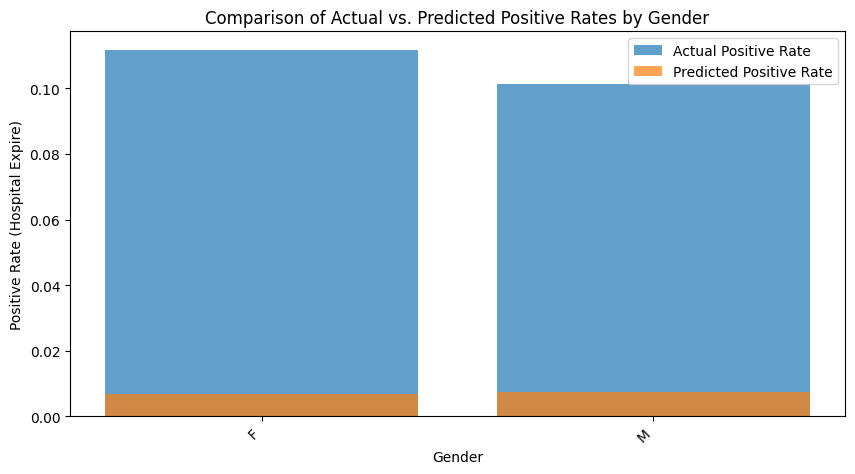

In [ ]:
# ----- Plotting Comparison of Actual vs. Predicted Positive Rates by Gender -----
plt.figure(figsize=(10, 5))
# Using the index (which is GENDER) for the x-axis
plt.bar(gender_fairness_df.index, gender_fairness_df["actual_positive_rate"], label="Actual Positive Rate", alpha=0.7)
plt.bar(gender_fairness_df.index, gender_fairness_df["predicted_positive_rate"], label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Gender")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Gender")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

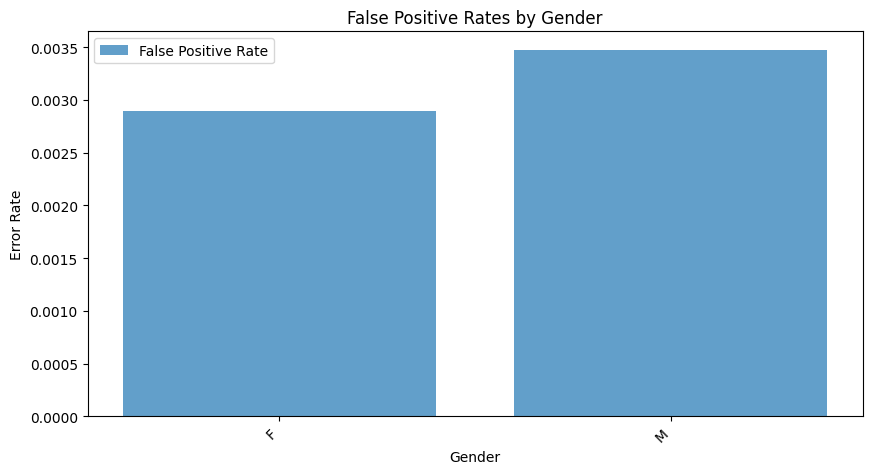

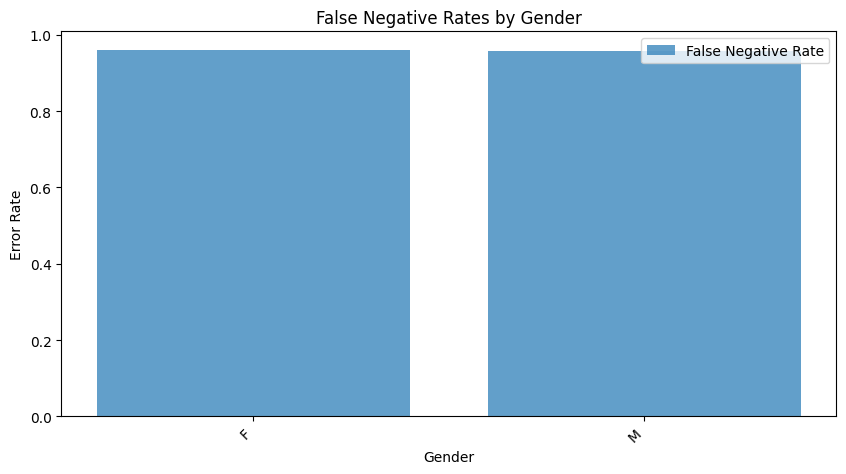

In [ ]:
# ----- Plotting False Positive Rates by Gender -----
plt.figure(figsize=(10, 5))
plt.bar(gender_bias_df["Gender"], gender_bias_df["False Positive Rate"], label="False Positive Rate", alpha=0.7)
plt.xlabel("Gender")
plt.ylabel("Error Rate")
plt.title("False Positive Rates by Gender")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

# ----- Plotting False Negative Rates by Gender -----
plt.figure(figsize=(10, 5))
plt.bar(gender_bias_df["Gender"], gender_bias_df["False Negative Rate"], label="False Negative Rate", alpha=0.7)
plt.xlabel("Gender")
plt.ylabel("Error Rate")
plt.title("False Negative Rates by Gender")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

Fairness Analysis by Religion:
                        total_samples  positive_actual  positive_predicted  \
RELIGION                                                                     
7TH DAY ADVENTIST                  73                5                   1   
BAPTIST                            28                8                   0   
BUDDHIST                          217               19                   1   
CATHOLIC                        18267             1854                 108   
CHRISTIAN SCIENTIST               337               29                   1   
EPISCOPALIAN                      693               63                   3   
GREEK ORTHODOX                    418               38                   3   
HEBREW                             16                4                   0   
HINDU                              70                9                   1   
JEHOVAH'S WITNESS                 127               16                   0   
JEWISH                           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


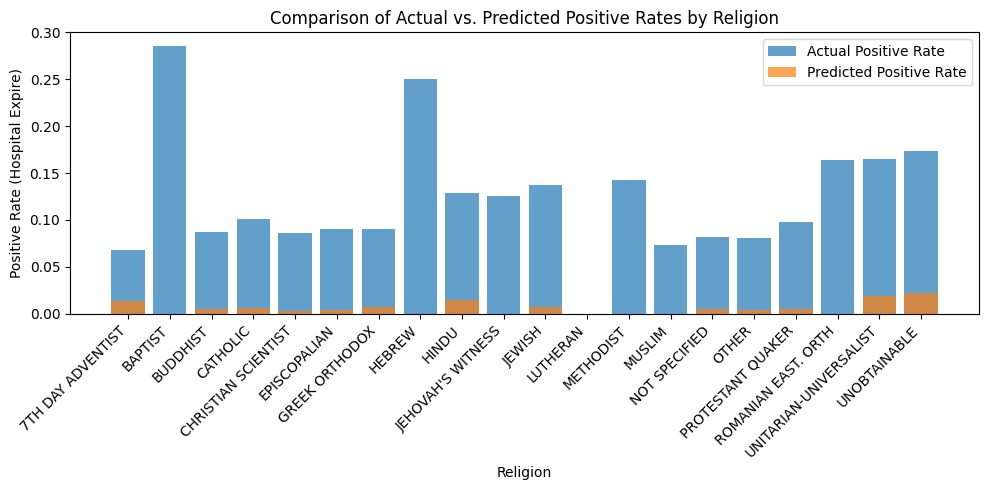

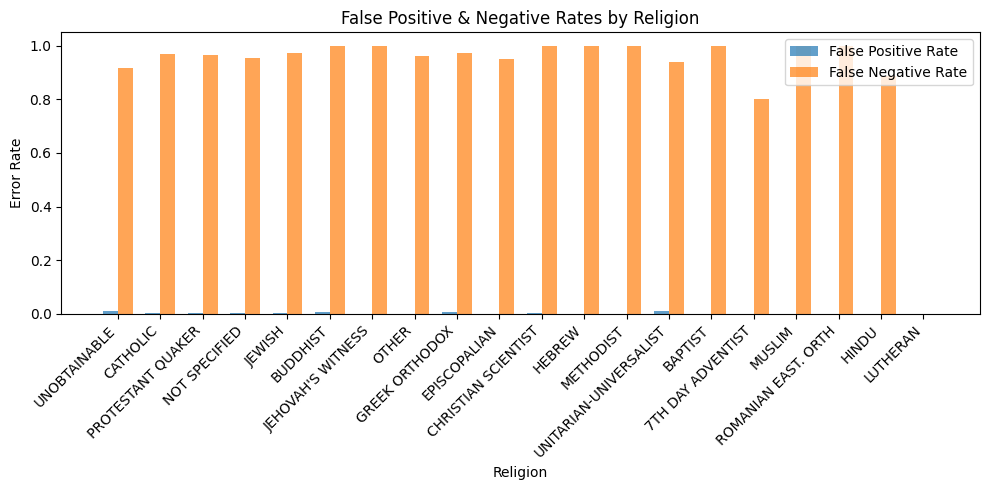

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ------------------------------
# 1. Fairness Analysis by Religion
# ------------------------------
# Group the data by RELIGION and compute counts and positive cases
religion_fairness_df = ehr_data.groupby("RELIGION").agg(
    total_samples=("RELIGION", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")           # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
religion_fairness_df["actual_positive_rate"] = religion_fairness_df["positive_actual"] / religion_fairness_df["total_samples"]
religion_fairness_df["predicted_positive_rate"] = religion_fairness_df["positive_predicted"] / religion_fairness_df["total_samples"]

# Display the fairness results
print("Fairness Analysis by Religion:")
print(religion_fairness_df)


# ------------------------------
# 2. Bias Analysis by Religion (Error Rates via Confusion Matrix)
# ------------------------------
# Store results per religion
religion_analysis = []

for religion in ehr_data["RELIGION"].unique():
    subset = ehr_data[ehr_data["RELIGION"] == religion]

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):  # Normal binary case
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Only one class present
        tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        print(f"Unexpected confusion matrix shape for {religion}: {cm.shape}")
        continue

    # Compute False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    religion_analysis.append({
        "Religion": religion,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert the analysis to a DataFrame and display the results
religion_bias_df = pd.DataFrame(religion_analysis)
print("\nBias Analysis (Error Rates) by Religion:")
print(religion_bias_df)


# ------------------------------
# 3. Plotting: Actual vs. Predicted Positive Rates by Religion
# ------------------------------
plt.figure(figsize=(10, 5))
# Using the index (i.e. the religion names) for the x-axis labels
plt.bar(religion_fairness_df.index, religion_fairness_df["actual_positive_rate"],
        label="Actual Positive Rate", alpha=0.7)
plt.bar(religion_fairness_df.index, religion_fairness_df["predicted_positive_rate"],
        label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Religion")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Religion")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# ------------------------------
# 4. Plotting: Combined False Positive and False Negative Rates by Religion
# ------------------------------
# Define positions for grouped bars
index = np.arange(len(religion_bias_df))
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(index, religion_bias_df["False Positive Rate"], bar_width, label="False Positive Rate", alpha=0.7)
plt.bar(index + bar_width, religion_bias_df["False Negative Rate"], bar_width, label="False Negative Rate", alpha=0.7)

plt.xlabel("Religion")
plt.ylabel("Error Rate")
plt.title("False Positive & Negative Rates by Religion")
plt.xticks(index + bar_width / 2, religion_bias_df["Religion"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
religion_fairness_df.to_csv('religion_fairness_df.csv')
religion_bias_df.to_csv('religion_bias_df.csv')

Fairness Analysis by Marital Status:
                   total_samples  positive_actual  positive_predicted  \
MARITAL_STATUS                                                          
DIVORCED                    3202              318                  18   
LIFE PARTNER                  15                0                   0   
MARRIED                    24073             2584                 196   
SEPARATED                    570               54                   5   
SINGLE                     13199             1084                  60   
UNKNOWN (DEFAULT)            344               65                  11   
WIDOWED                     7185             1045                  58   

                   actual_positive_rate  predicted_positive_rate  
MARITAL_STATUS                                                    
DIVORCED                       0.099313                 0.005621  
LIFE PARTNER                   0.000000                 0.000000  
MARRIED                        0.1073

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


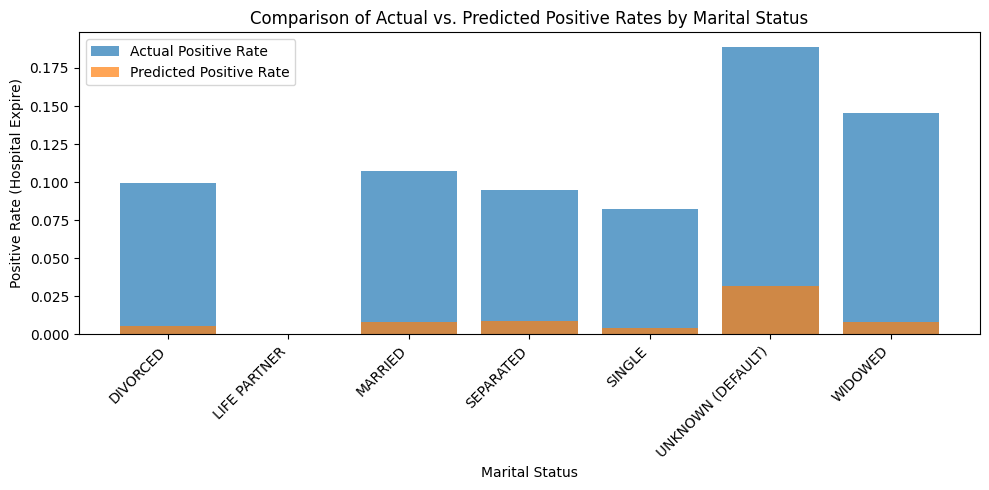

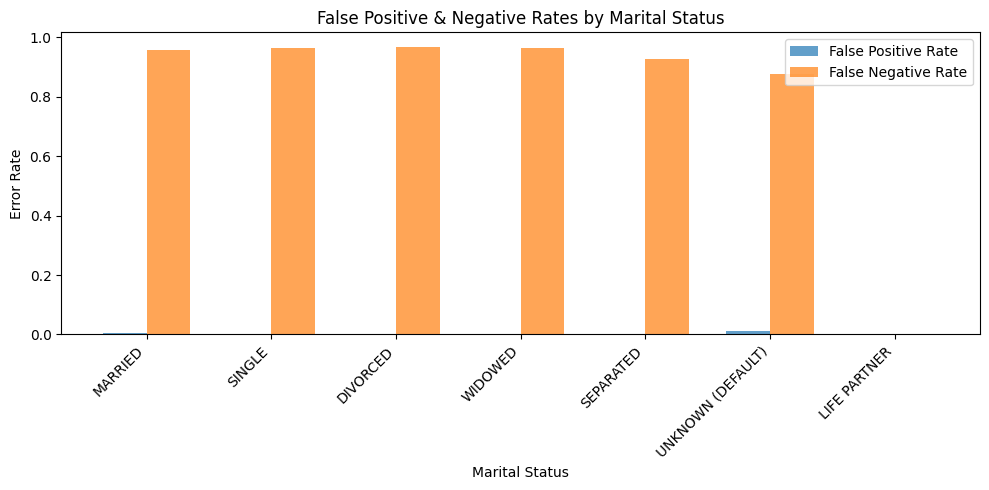

In [ ]:
# ------------------------------
# 1. Fairness Analysis by Marital Status
# ------------------------------
# Group the data by MARITAL_STATUS and compute counts and positive cases
marital_fairness_df = ehr_data.groupby("MARITAL_STATUS").agg(
    total_samples=("MARITAL_STATUS", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")           # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
marital_fairness_df["actual_positive_rate"] = marital_fairness_df["positive_actual"] / marital_fairness_df["total_samples"]
marital_fairness_df["predicted_positive_rate"] = marital_fairness_df["positive_predicted"] / marital_fairness_df["total_samples"]

# Display the fairness results
print("Fairness Analysis by Marital Status:")
print(marital_fairness_df)


# ------------------------------
# 2. Bias Analysis by Marital Status (Error Rates via Confusion Matrix)
# ------------------------------
# Store results per marital status
marital_analysis = []

for status in ehr_data["MARITAL_STATUS"].unique():
    subset = ehr_data[ehr_data["MARITAL_STATUS"] == status]

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):  # Typical binary classification
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Only one class is present
        tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        print(f"Unexpected confusion matrix shape for {status}: {cm.shape}")
        continue

    # Compute False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    marital_analysis.append({
        "Marital Status": status,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert the analysis to a DataFrame and display the results
marital_bias_df = pd.DataFrame(marital_analysis)
print("\nBias Analysis (Error Rates) by Marital Status:")
print(marital_bias_df)


# ------------------------------
# 3. Plotting: Actual vs. Predicted Positive Rates by Marital Status
# ------------------------------
plt.figure(figsize=(10, 5))
# Plotting using the index (MARITAL_STATUS) for the x-axis labels
plt.bar(marital_fairness_df.index, marital_fairness_df["actual_positive_rate"],
        label="Actual Positive Rate", alpha=0.7)
plt.bar(marital_fairness_df.index, marital_fairness_df["predicted_positive_rate"],
        label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Marital Status")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Marital Status")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# ------------------------------
# 4. Combined Plot: False Positive & Negative Rates by Marital Status
# ------------------------------
# Define positions for grouped bars
index = np.arange(len(marital_bias_df))
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(index, marital_bias_df["False Positive Rate"], bar_width, label="False Positive Rate", alpha=0.7)
plt.bar(index + bar_width, marital_bias_df["False Negative Rate"], bar_width, label="False Negative Rate", alpha=0.7)
plt.xlabel("Marital Status")
plt.ylabel("Error Rate")
plt.title("False Positive & Negative Rates by Marital Status")
plt.xticks(index + bar_width / 2, marital_bias_df["Marital Status"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Actual outcomes and model predictions
y_true = ehr_data['HOSPITAL_EXPIRE_FLAG'].values  # Actual hospital outcome
y_pred = ehr_data['predictions'].values            # Predicted outcomes

# List of sensitive features to evaluate
sensitive_features_list = ['GENDER', 'ETHNICITY', 'RELIGION', 'MARITAL_STATUS']

# Loop through each sensitive feature and compute fairness metrics
for feature in sensitive_features_list:
    groups = ehr_data[feature].values
    dem_parity = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)
    eq_odds = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)

    print(f"--- {feature} ---")
    print(f"Demographic Parity Difference: {dem_parity:.4f}")
    print(f"Equalized Odds Difference: {eq_odds:.4f}\n")


--- GENDER ---
Demographic Parity Difference: 0.0004
Equalized Odds Difference: 0.0028

--- ETHNICITY ---
Demographic Parity Difference: 0.0435
Equalized Odds Difference: 0.5000

--- RELIGION ---
Demographic Parity Difference: 0.0217
Equalized Odds Difference: 0.2000

--- MARITAL_STATUS ---
Demographic Parity Difference: 0.0320
Equalized Odds Difference: 0.1231



In [ ]:
marital_fairness_df.to_csv('marital_fairness_df.csv')
marital_bias_df.to_csv('marital_bias_df.csv')